En este codigo se hallan todos los máximos para cada GRB dentro del error definido como el máximo entre el error en posición y el error de HAWC, me ayudé con una IA para los detalles.

Probabilidad >3σ (KDE promedio por seed): 0.014694186741176979
Directamente de los datos: 0.0036383682469680267


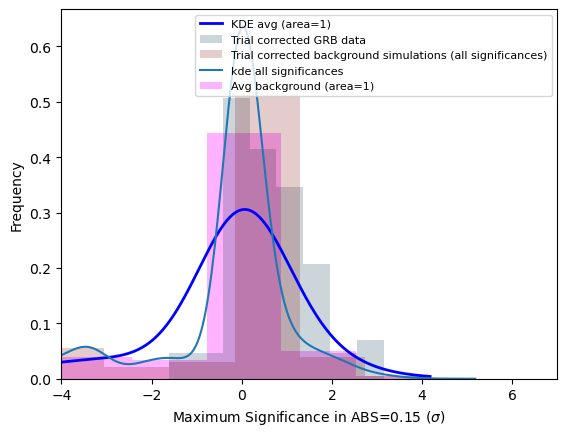

Probabilidad >3σ (KDE promedio por seed): 0.01746748483949593
Directamente de los datos: 0.009475539885412075


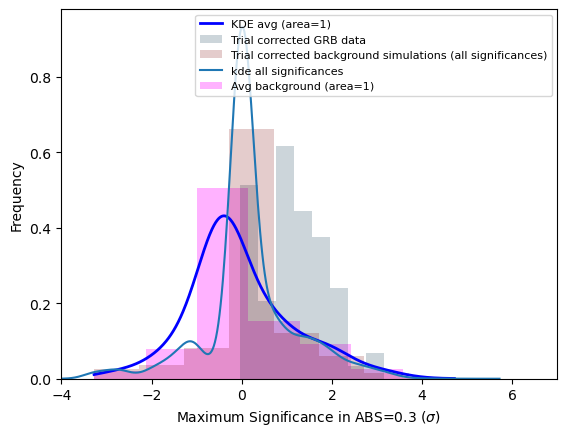

Probabilidad >3σ (KDE promedio por seed): 0.038666099009593245
Directamente de los datos: 0.035706240144176615


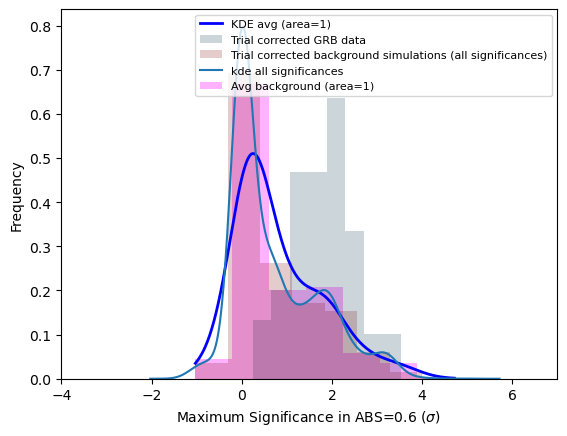

,PSF,T_stat,n_elem,Crit_val,p_val (Fisher),sig (Fisher)
0,0.15,202.381271,73,175.197567,1.402212e-03,2.988400
1,0.30,271.479456,73,175.197567,1.374064e-09,5.945977
2,0.60,263.867717,73,175.197567,8.224753e-09,5.645716


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy.stats import kstest, gaussian_kde, chi2,norm

# ==========================
# CONFIG
# ==========================
n_norm = 1 
# n_norm=1
# plt.style.use("dark_background")
# plt.rcParams.update({
#     "axes.facecolor": "none",
#     "figure.facecolor": "none",
#     "savefig.facecolor": "none",
#     "text.color": "white",
#     "axes.labelcolor": "white",
#     "xtick.color": "white",
#     "ytick.color": "white",
#     "legend.edgecolor": "white"
# })

# ==========================
# MAIN CODE
# ==========================
PSF = [0.15,0.3,0.6]
j = 2
Nbins=8
Nbins_big=14
sig_name = 'sigma_post'
Fisher_T_statistics = {'PSF': [], 'T_stat': [], 'n_elem': [], 'Crit_val': []}
bw_meth='scott'
bw_meth='silverman'
def normal_fixedA(x, mu, sigma, A0):
    """Gaussian with amplitude A0 fixed externally."""
    return A0 * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

for i in PSF:
    name_1 = f'Files/Max/grb_all_seed_maxima_PSF{i}_free.csv'
    df_1 = pd.read_csv(name_1)

    name_2 = f'Files/Max/grb_all_seed_maxima_PSF{i}_fixed.csv'
    df_2 = pd.read_csv(name_2)

    name_3 = f'Files/Max/grb_all_seed_maxima_PSF{i}_free_data.csv'
    df_3 = pd.read_csv(name_3)

    name_4 = f'Files/Max/grb_all_seed_maxima_PSF{i}_fixed_data.csv'
    df_4 = pd.read_csv(name_4)

    j = j + 1
    data = df_1[sig_name]
    ################################################
    # Describing the data
    ################################################
    mu = data.mean()
    std = data.std()
    S = data.skew()
    K = data.kurt()
    Tstat, p_value = kstest(data, 'norm', args=(mu, std))
    ################################################
    #Finding average distribution
    ################################################
    hist, bins = np.histogram(data, bins=Nbins, density=True)
    A0 = hist.max()
    mu0 = data.mean()
    sigma0 = data.std()
    centers = 0.5 * (bins[:-1] + bins[1:]) 
    ################################################
    #Fitting a normal distribution
    ###############################################
    popt, pcov = curve_fit(
        lambda x, mu, sigma: normal_fixedA(x, mu, sigma, A0),
        centers,
        hist,
        p0=[mu0, sigma0]
    )
    mu_fit, sigma_fit = popt
    x_fit = np.linspace(centers.min(), centers.max(), 2000)
    
    ################################################
    #Finding average distribution
    #############################################
    #    --- Promedio por seed (bin a bin, en densidad) ---
    groups = df_1.groupby('seed')['sigma_post']
    # Misma malla de bins para todos los seeds
    bins = np.linspace(df_1['sigma_post'].min(), df_1['sigma_post'].max(), Nbins)
    binw = np.diff(bins)
    centers = 0.5 * (bins[:-1] + bins[1:])
    # Hist densidad por seed (cada seed con el mismo peso)
    h_per_seed = []
    for _, g in groups:
        h, _ = np.histogram(g.values, bins=bins, density=True)
        h_per_seed.append(h)
    mean_hist = np.mean(h_per_seed, axis=0)          # densidad promedio por seed

    # --- KDE de la distribución promedio (usando pesos de masa por bin) ---
    # Pesos ~ masa de probabilidad promedio en cada bin: densidad * ancho
    w = (mean_hist * binw)
    w = w / w.sum()                                  # normaliza a 1 (como probabilidad)
    # gaussian_kde con puntos en los centros y pesos por bin
    kde_avg = gaussian_kde(centers, weights=w, bw_method=0.40)
    x_kde_avg = np.linspace(bins.min(), bins.max(), 600)
    y_kde_avg = kde_avg(x_kde_avg)

    # Escalar ambas (histograma promedio y KDE) a tu norma n_norm
    # (área del histograma promedio en densidad es 1; lo llevamos a n_norm)
    scale = n_norm

    # Probabilidad de cola >3σ usando el KDE promedio
    def pdf_avg(x):
        return float(kde_avg([x]))
    p_val_right = scipy.integrate.quad(pdf_avg, 3, np.inf, limit=2000)[0]
    print('Probabilidad >3σ (KDE promedio por seed):', p_val_right)
    print('Directamente de los datos:', len(data[data > 3]) / len(data))
    ################################################
    # --- Non-parametric density estimate and visualization ---
    ################################################
    data=df_1[sig_name]
    kde = gaussian_kde(data, bw_method=0.25)  
    x_kde = np.linspace(data.min() - 1, data.max() + 1, 400)
    y_kde = kde(x_kde)

    def pdf(x):
        return float(kde([x]))
    # p_val_right = scipy.integrate.quad(pdf, 3, np.inf, limit=200)[0]
    # print('The probability of values >3 sigma (non-parametric):', p_val_right)
    # print('Directly from data:', len(data[data > 3]) / len(data))
    
    ################################################
    # Fisher Test
    ################################################
    sigma_lim=5
    def PVal(x_data):
        p_val=-2*np.log(scipy.integrate.quad(kde_avg,x_data,np.inf,limit=200)[0])
        return p_val
    GRB_data=df_3[df_3[sig_name]<sigma_lim][sig_name]
    Fisher_statistic=GRB_data.apply(PVal).sum();n_elem=len(GRB_data) 
    # #Finding the critical value
    Crit_val=chi2.ppf(0.95,2*n_elem)
    Fisher_T_statistics['PSF'].append(i)
    Fisher_T_statistics['T_stat'].append(Fisher_statistic)
    Fisher_T_statistics['n_elem'].append(n_elem)
    Fisher_T_statistics['Crit_val'].append(Crit_val)
    ################################################  
    #Plots
    ################################################
    # --- Normalización global a la misma escala (área = n_norm) ---
    area_hist = np.sum(mean_hist * binw)  # área real del histograma promedio
    # Histograma promedio escalado a área 1
    plt.bar(centers, mean_hist / np.sum(mean_hist * binw), width=binw,
            color='magenta', alpha=0.3, label='Avg background (area=1)')

    # KDE escalada a área 1
    scale = 1 / np.trapz(y_kde_avg, x_kde_avg)
    scale=1
    plt.plot(x_kde_avg, y_kde_avg * scale, lw=2, color='blue',
            label='KDE avg (area=1)')

    # Datos reales también en densidad
    df_3[sig_name].hist(bins=Nbins, density=True, alpha=0.2,color=f'#003049', label='Trial corrected GRB data')
    df_1[sig_name].hist(bins=Nbins, density=True,alpha=0.2,color=f'#780000', label='Trial corrected background simulations (all significances)')
    scale = 1 / np.trapz(y_kde, x_kde)
    # Labels, legend, limits
    plt.plot(x_kde,y_kde*scale,label='kde all significances')
    plt.grid(False)
    plt.legend(fontsize=8)
    plt.xlim([-4, 7])
    plt.ylabel('Frequency')
    plt.xlabel(fr'Maximum Significance in ABS={i} ($\sigma$) ')

    # Save with transparent background
    plt.savefig(f"plots/PSF{i}_wData.png", dpi=300, bbox_inches='tight')
    plt.show()
    
# Collect Fisher test results
Fisher_Test = pd.DataFrame(Fisher_T_statistics)
from scipy.stats import norm
Fisher_Test['p_val (Fisher)']=Fisher_Test.apply(lambda row: chi2.sf(row['T_stat'],2*row['n_elem']),axis=1)
Fisher_Test['sig (Fisher)']=Fisher_Test.apply(lambda row: norm.isf(row['p_val (Fisher)']),axis=1)
Fisher_Test


Veamos el histograma promedio por dentro

In [2]:
mean_hist

array([0.04399034, 0.66779306, 0.20131034, 0.20871479, 0.05915594,
       0.03617402, 0.00111454])

In [3]:
len(mean_hist)

7

Here we calculate differently the final distribution, we average significance per GRB and those averages dignificances are analyzed. We realized later that this way was not the right way, since averaging significances that way, does not extract the correct information from data

Probabilidad >3σ (KDE promedio por seed): 3.1661486498492036e-23
Directamente de los datos: 0.0


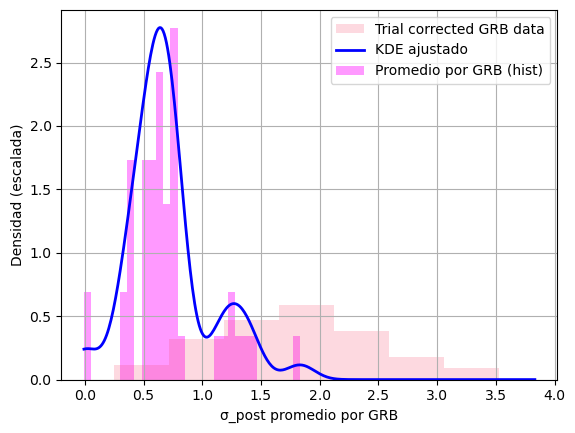

1.8324374687321594

In [4]:
bins=30


# Promedio por GRB
grb_mean = df_1.groupby('GRB')['sigma_post'].mean()

# Calcular histograma (no en densidad, porque luego lo ajustamos)
data, bins = np.histogram(grb_mean, bins=bins, density=True)

# Centros de los bins
centers = 0.5 * (bins[:-1] + bins[1:])

# KDE sobre los valores promediados por GRB
kde = gaussian_kde(grb_mean, bw_method=0.35)

# Evaluar la KDE en los mismos centros
x_kde = np.linspace(bins.min(), bins.max()+2, 400)
y_kde = kde(x_kde)

# Escalar la KDE al histograma para que coincidan en altura
scale = data.max() / y_kde.max()
def pdf_avg(x):
    return float(kde([x]))
p_val_right = scipy.integrate.quad(pdf_avg, 3, np.inf, limit=2000)[0]
print('Probabilidad >3σ (KDE promedio por seed):', p_val_right)
print('Directamente de los datos:', len(grb_mean[grb_mean > 3]) / len(grb_mean))
# Graficar
plt.figure()
plt.bar(centers, data, width=np.diff(bins), alpha=0.4, color='magenta', label='Promedio por GRB (hist)')
df_3[sig_name].hist(
    bins=7, color=f'#f{j}4266', alpha=0.2,
    weights=np.ones(len(df_3)) * (n_norm/len(df_3)),
    label='Trial corrected GRB data',
    density=True
)
plt.plot(x_kde, y_kde * scale, lw=2, color='blue', label='KDE ajustado')
plt.xlabel('σ_post promedio por GRB')
plt.ylabel('Densidad (escalada)')
plt.legend()
plt.show()
grb_mean.max()

In [5]:
GRB='GRB150101641'
GRB='GRB170817529'
# df_1[df_1['GRB']== GRB]['sigma_post'].hist()
# # len(df_3),len(groups),len(all_data)
# df_1[df_1['GRB']== GRB]['sigma_post'].mean()


Todas las medias de los datos se ven así

In [6]:
df_1.groupby('GRB')['sigma_post'].mean()

GRB
GRB150101641    1.832437
GRB150110923    0.751416
GRB150120123    1.171456
GRB150811849   -0.007446
GRB150819440    0.670574
GRB151229285    0.323819
GRB160612842    0.000000
GRB160624477    1.237524
GRB160714097    0.585758
GRB160806584    0.822986
GRB160821937    1.390260
GRB160822672    0.647442
GRB170206453    1.244163
GRB170318644    0.734153
GRB170403583    0.694156
GRB170708046    0.707444
GRB170803729    0.571006
GRB170816599    0.753428
GRB170817529    1.129671
GRB170826369    0.521301
GRB171007498    0.655051
GRB180204109    0.660340
GRB180402406    0.397056
GRB180418281    0.779668
GRB180715755    0.760605
GRB180718082    0.776986
GRB180805543    0.377031
GRB181125371    0.522496
GRB190427190    0.545341
GRB190515190    0.405449
GRB200605762    0.420561
GRB200623138    0.518348
GRB201008443    0.555942
GRB201214672    0.736772
GRB210323918    1.415771
GRB210618072    0.530369
GRB210827416    0.316130
GRB211024065    0.584814
GRB220412713    0.611496
GRB220418720    0.393

Todas las distribuciones de las muestras juntas

seed
1      Axes(0.125,0.11;0.775x0.77)
10     Axes(0.125,0.11;0.775x0.77)
100    Axes(0.125,0.11;0.775x0.77)
101    Axes(0.125,0.11;0.775x0.77)
102    Axes(0.125,0.11;0.775x0.77)
                  ...             
95     Axes(0.125,0.11;0.775x0.77)
96     Axes(0.125,0.11;0.775x0.77)
97     Axes(0.125,0.11;0.775x0.77)
98     Axes(0.125,0.11;0.775x0.77)
99     Axes(0.125,0.11;0.775x0.77)
Name: sigma_post, Length: 202, dtype: object

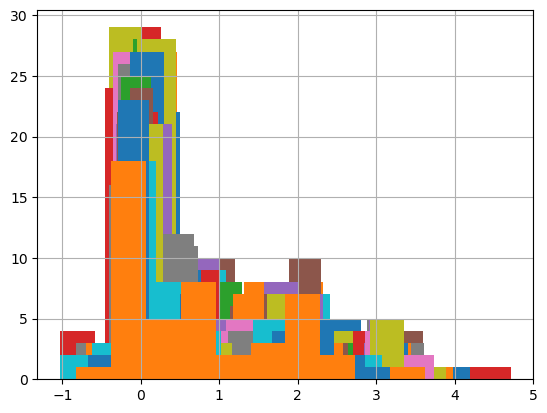

In [7]:
df_1.groupby('seed')['sigma_post'].hist()

In [8]:
 # =====================================
#   LIBRERÍAS
# =====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =====================================
#   RUTAS DE ARCHIVOS (dados por ti)
# =====================================
path = '/lustre/hawcz01/scratch/userspace/jorgeamontes/GRB_KN/data/ULs/config/Data/GRB_List_z=0.csv'
path_FERMI = '/lustre/hawcz01/scratch/userspace/smfraijac/Catalogs/Fermi/GRBsList_allDataBase.csv'

# =====================================
#   LECTURA DE DATOS
# =====================================
# times = pd.read_csv(path)  # <-- Ya no lo usamos para Tstart; lo dejo comentado por si lo necesitas luego
FERMI = pd.read_csv(path_FERMI)

# Asegurar que Tent-T0 sea numérico
FERMI['Tent-T0'] = pd.to_numeric(FERMI['Tent-T0'], errors='coerce')

# =====================================
#   CREAR TRÁNSITOS 1 Y 2 (Tstart desde FERMI)
# =====================================
FERMI_1 = FERMI.copy()
FERMI_1['transit'] = 'transit_1'

FERMI_2 = FERMI.copy()
FERMI_2['transit'] = 'transit_2'
FERMI_2['Tent-T0'] = FERMI_2['Tent-T0'] + 24  # segunda órbita

# Combinar
FERMI_combined = pd.concat([FERMI_1, FERMI_2], ignore_index=True)
FERMI_combined = FERMI_combined.sort_values(['GRB', 'transit']).reset_index(drop=True)
FERMI_combined = FERMI_combined.dropna(subset=['Tent-T0'])

# =====================================
#   DEFINIR PARES A EXCLUIR CON df_3
# =====================================
# df_3 debe tener columnas: ['GRB','sigma_post','transit']
# Construimos las listas de exclusión por caso
DF_1_2sig_pairs = df_3[(df_3['sigma_post'] > 0) & (df_3['sigma_post'] < 5)][['GRB','transit']].drop_duplicates()
DF_1_4sig_pairs = df_3[(df_3['sigma_post'] > 0) & (df_3['sigma_post'] < 4)][['GRB','transit']].drop_duplicates()
DF_1_1sig_pairs = df_3[(df_3['sigma_post'] < 0.3) ][['GRB','transit']].drop_duplicates()

exclude_pairs_2 = DF_1_2sig_pairs.apply(tuple, axis=1).tolist()
exclude_pairs_4 = DF_1_4sig_pairs.apply(tuple, axis=1).tolist()
exclude_pairs_1 = DF_1_1sig_pairs.apply(tuple, axis=1).tolist()

# =====================================
#   CONSTRUIR FERMI_wo_* SEGÚN EXCLUSIONES
# =====================================
FERMI_combined['pair'] = list(zip(FERMI_combined['GRB'], FERMI_combined['transit']))

FERMI_wo_GRBs_2 = FERMI_combined[FERMI_combined['pair'].isin(exclude_pairs_2)].copy()
FERMI_wo_GRBs_4 = FERMI_combined[~FERMI_combined['pair'].isin(exclude_pairs_4)].copy()
FERMI_wo_GRBs_1 = FERMI_combined[FERMI_combined['pair'].isin(exclude_pairs_1)].copy()

# Limpieza
for df_tmp in (FERMI_combined, FERMI_wo_GRBs_2, FERMI_wo_GRBs_4):
    df_tmp.drop(columns='pair', inplace=True, errors='ignore')

In [9]:
len(FERMI_wo_GRBs_1),len(FERMI_wo_GRBs_2)
df_3[(df_3['sigma_post'] < 0.3) ]

,GRB,transit,seed,ra_max,dec_max,max_sigma,region_size_deg,trials_factor,p_pre,p_post,sigma_post
56,GRB211024065,transit_1,GRB211024065_transit_1FINAL_C0,28.564453,-6.692254,0.248006,0.6,1.0,0.402065,0.402065,0.248006


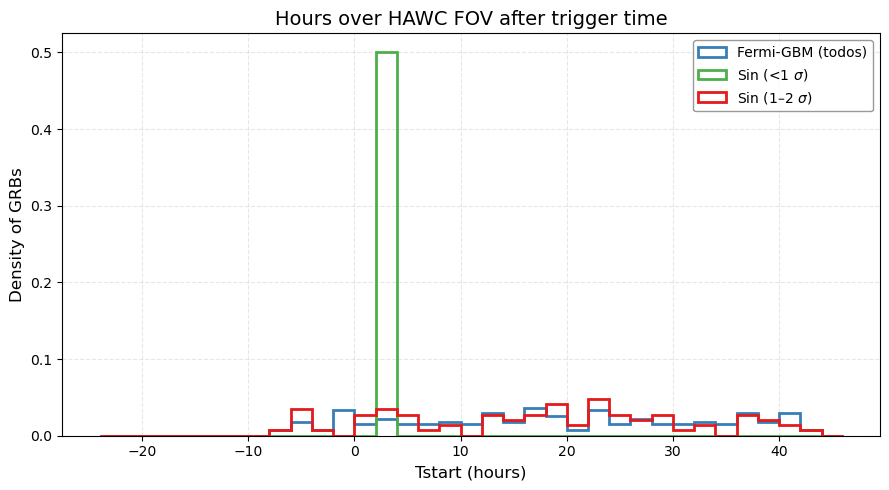

In [10]:
# =====================================
#   HISTOGRAMAS COMO CONTORNOS
# =====================================
bins = np.arange(-24, 48, 2)
plt.figure(figsize=(9, 5))

plt.hist(
    FERMI_combined['Tent-T0'],
    bins=bins,
    density=True,
    histtype='step',
    linewidth=2.0,
    color='#377eb8',
    label=r'Fermi-GBM (todos)'
)

plt.hist(
    FERMI_wo_GRBs_1['Tent-T0'],
    bins=bins,
    density=True,
    histtype='step',
    linewidth=2.0,
    color='#4daf4a',
    label=r'Sin (<1 $\sigma$)'
)

plt.hist(
    FERMI_wo_GRBs_2['Tent-T0'],
    bins=bins,
    density=True,
    histtype='step',
    linewidth=2.0,
    color='#e41a1c',
    label=r'Sin (1–2 $\sigma$)'
)


plt.xlabel('Tstart (hours)', fontsize=12)
plt.ylabel('Density of GRBs', fontsize=12)
plt.title('Hours over HAWC FOV after trigger time', fontsize=14)
plt.legend(frameon=True, facecolor='white', edgecolor='gray', fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

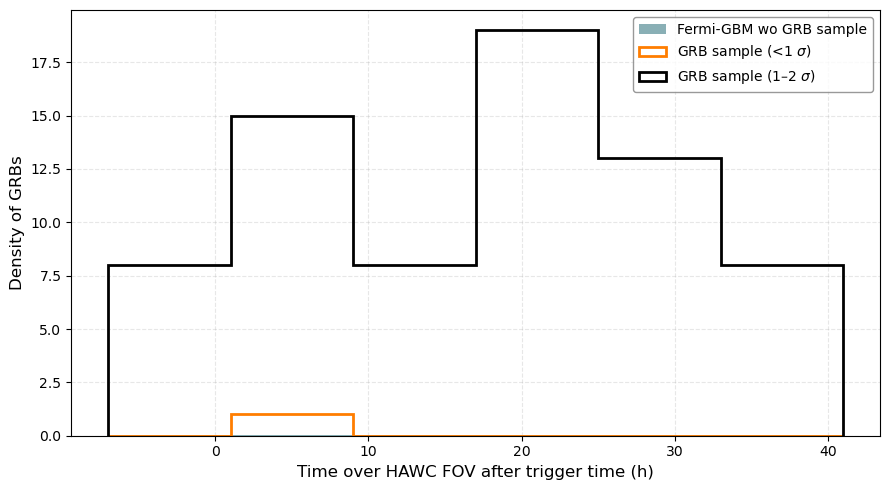

In [11]:
# =====================================
#   HISTOGRAMAS CLAROS Y DISTINGUIBLES
# =====================================
bins = np.arange(-7, 42, 8)
# bins=8
plt.figure(figsize=(9, 5))

# Paleta bien contrastante
color_all = '#15616d'     # Azul fuerte
color_lt1 = '#ff7d00'     # Verde
color_1to2 = '#333d29'    # Rojo intenso

# --- Todos los GRBs
plt.hist(
    FERMI_combined['Tent-T0'],
    bins=bins,
    density=True,
    alpha=0.5,
    label=r'Fermi-GBM wo GRB sample',
    color=color_all,
    linewidth=1.0
)

# --- Sin (<1σ)

# --- Sin (1–2σ)

plt.hist(
    FERMI_wo_GRBs_1['Tent-T0'],
    bins=bins,
    # density=True,
    alpha=1,
    histtype='step',
    label=r'GRB sample (<1 $\sigma$)',
    color=color_lt1,
    linewidth=2.0
)
plt.hist(
    FERMI_wo_GRBs_2['Tent-T0'],
    bins=bins,
    # density=True,
    alpha=1,
    label=r'GRB sample (1–2 $\sigma$)',
    # color=color_1to2,
    histtype='step',
    edgecolor='black',
    linewidth=2.0
)
plt.xlabel('Time over HAWC FOV after trigger time (h)', fontsize=12)
plt.ylabel('Density of GRBs', fontsize=12)
# plt.title('Hours over HAWC FOV after trigger time', fontsize=14)
plt.legend(frameon=True, facecolor='white', edgecolor='gray', fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

(0.0, 1.0)

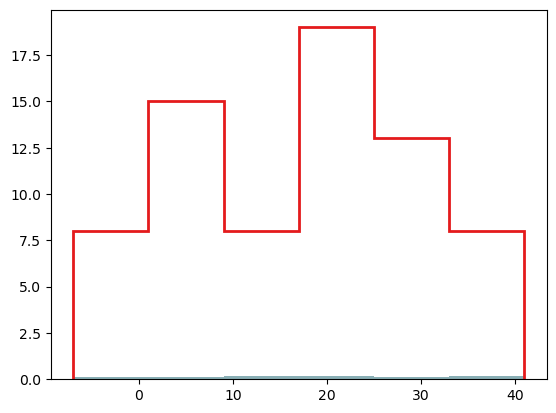

In [12]:
plt.hist(
    FERMI_combined['Tent-T0'],
    bins=bins,
    # density=True,
    alpha=0.5,
    label=r'Fermi-GBM wo GRB sample',
    color=color_all,
    linewidth=1.0,
    weights=np.ones(len(FERMI_combined['Tent-T0'])) * (n_norm/len(FERMI_combined['Tent-T0']))
)
plt.hist(
    FERMI_wo_GRBs_2['Tent-T0'],
    bins=bins,
    # density=True,
    histtype='step',
    linewidth=2.0,
    color='#e41a1c',
    label=r'Sin (1–2 $\sigma$)'
)
from scipy.stats import ks_2samp
stat, p_val=ks_2samp(FERMI_combined['Tent-T0'],FERMI_combined['Tent-T0'])
data=FERMI_combined['Tent-T0']
stat, p_val


In [13]:
FERMI_wo_GRBs_1['Tent-T0'].sort_values(ascending=True)

130    2.109354
Name: Tent-T0, dtype: float64

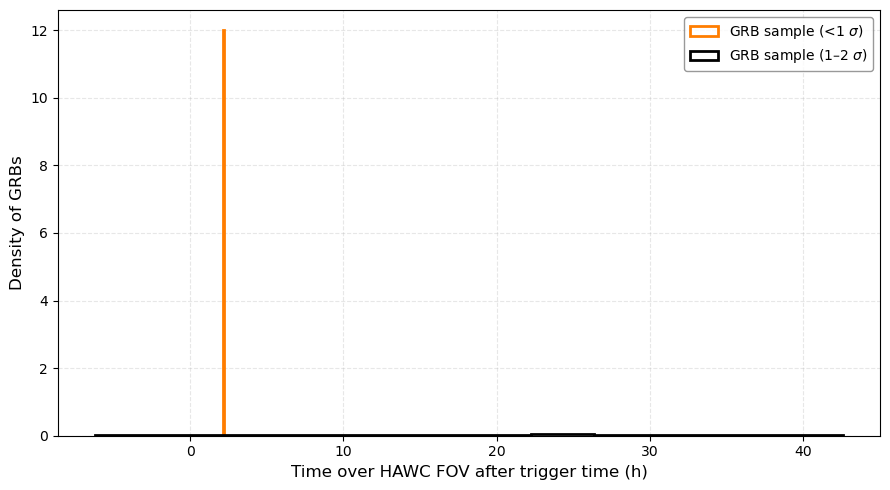

In [14]:
# =====================================
#   HISTOGRAMAS CLAROS Y DISTINGUIBLES
# =====================================
bins = np.arange(-13, 48, 2)
bins=12
plt.figure(figsize=(9, 5))

# Paleta bien contrastante
color_all = '#15616d'     # Azul fuerte
color_lt1 = '#ff7d00'     # Verde
color_1to2 = '#333d29'    # Rojo intenso

# --- Todos los GRBs
# plt.hist(
#     FERMI_combined['Tent-T0'],
#     bins=bins,
#     density=True,
#     alpha=0.5,
#     label=r'Fermi-GBM wo GRB sample',
#     color=color_all,
#     linewidth=1.0
# )

# --- Sin (<1σ)

# --- Sin (1–2σ)

plt.hist(
    FERMI_wo_GRBs_1['Tent-T0'],
    bins=bins,
    density=True,
    alpha=1,
    histtype='step',
    label=r'GRB sample (<1 $\sigma$)',
    color=color_lt1,
    linewidth=2.0
)
plt.hist(
    FERMI_wo_GRBs_2['Tent-T0'],
    bins=bins,
    density=True,
    alpha=1,
    label=r'GRB sample (1–2 $\sigma$)',
    # color=color_1to2,
    histtype='step',
    edgecolor='black',
    linewidth=2.0
)
plt.xlabel('Time over HAWC FOV after trigger time (h)', fontsize=12)
plt.ylabel('Density of GRBs', fontsize=12)
# plt.title('Hours over HAWC FOV after trigger time', fontsize=14)
plt.legend(frameon=True, facecolor='white', edgecolor='gray', fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [15]:
DF=pd.merge(df_3,times,left_on='GRB',right_on='Name',how='inner')

DF[['GRB','sigma_post','transit','Tstart (h)']]
DF['Tstart (h)'] = DF.apply(
    lambda row: row['Tstart (h)'] + 24 if row['transit'] =='transit_2' else row['Tstart (h)'],
    axis=1
 )
DF_1_2sig=DF[(DF['sigma_post']>1)&(DF['sigma_post']<2)][['GRB','sigma_post','transit','Tstart (h)']]
DF_1sig=DF[(DF['sigma_post']<1)][['GRB','sigma_post','transit','Tstart (h)']]
DF_1_4sig=DF[(DF['sigma_post']>1)&(DF['sigma_post']<4)][['GRB','sigma_post','transit','Tstart (h)']]
# DF_1_2sig[DF_1_2sig['Tstart (h)']<5]
DF_1_2sig['Tstart (h)']
DF_1_2sig.hist(bins=35)
DF

NameError: name 'times' is not defined

In [ ]:
# FERMI[FERMI['GRB'].isin(GRBs_sample)][Texit-Tmax]
FERMI['Tent-T0_y']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
        ...    
91    23.857633
92          NaN
93          NaN
94          NaN
95          NaN
Name: Tent-T0_y, Length: 96, dtype: float64

Estos GRBs tienen o no redshift


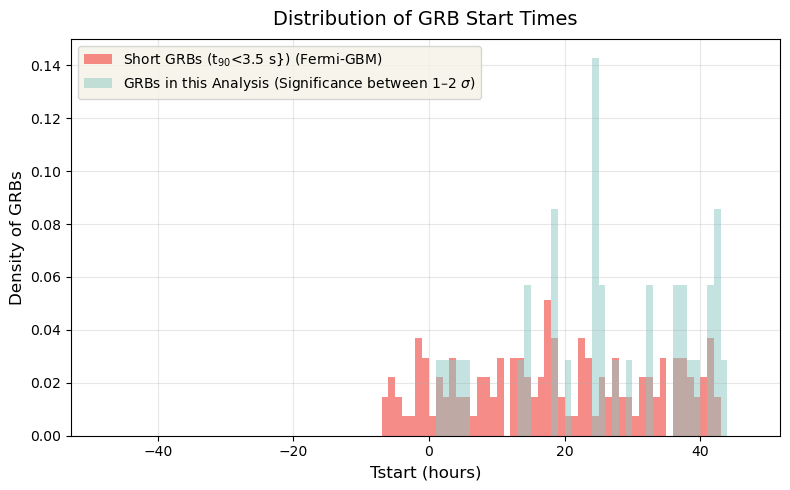

In [ ]:
# Limpieza de datos
FERMI.dropna(inplace=True)

# Cálculo de la segunda órbita y combinación de tiempos

Tstart_FERMI = FERMI['Tent-T0_x'].to_list() + FERMI['Tent-T0_y'].to_list()

# Figura y ejes
plt.figure(figsize=(8, 5))

# Histograma de GRBs cortos observados por Fermi
plt.hist(
    Tstart_FERMI, 
    bins=np.arange(-48,48,1), 
    density=True, 
    label=r'Short GRBs (t$_{90}$<3.5 s}) (Fermi-GBM)', 
    color='#f25c54', 
    alpha=0.7
)

# Histograma de los GRBs analizados en tu estudio
DF_1_2sig['Tstart (h)'].hist(
    bins=np.arange(-48,48,1), 
    density=True, 
    alpha=0.5, 
    label=r'GRBs in this Analysis (Significance between 1–2 $\sigma$)', 
    color='#8ac6c3'
)

# Personalización del gráfico
plt.xlabel('Tstart (hours)', fontsize=12)
plt.ylabel('Density of GRBs', fontsize=12)
plt.title('Distribution of GRB Start Times', fontsize=14, pad=10)
plt.legend(facecolor='#f5f3e7')
plt.grid(alpha=0.3)
plt.tight_layout()
print('Estos GRBs tienen o no redshift')
# Mostrar figura
plt.show()


In [ ]:
# Listas de GRBs a excluir (por ejemplo)
GRBs_sample1_4 = DF_1_4sig['GRB'].to_list()
GRBs_sample1_2 = DF_1_2sig['GRB'].to_list()

# Si también tienes los tránsitos asociados a cada GRB en esas tablas:
exclude_pairs_4 = DF_1_4sig[['GRB', 'transit']].apply(tuple, axis=1).tolist()
exclude_pairs_2 = DF_1_2sig[['GRB', 'transit']].apply(tuple, axis=1).tolist()

# Combinar ambas listas (si quieres excluir ambos conjuntos)
exclude_pairs = exclude_pairs_4 + exclude_pairs_2

# Ahora creamos la lista de pares en tu dataframe principal
FERMI_combined['pair'] = list(zip(FERMI_combined['GRB'], FERMI_combined['transit']))

# Filtramos los que NO están en la lista de exclusión
FERMI_wo_GRBs = FERMI_combined[~FERMI_combined['pair'].isin(exclude_pairs)].copy()
# --- Crear listas de pares (GRB, transit) para cada muestra ---
exclude_pairs_4 = DF_1_4sig[['GRB', 'transit']].apply(tuple, axis=1).tolist()
exclude_pairs_2 = DF_1_2sig[['GRB', 'transit']].apply(tuple, axis=1).tolist()

# --- Crear columna auxiliar con pares (GRB, transit) ---
FERMI_combined['pair'] = list(zip(FERMI_combined['GRB'], FERMI_combined['transit']))

# --- Filtrar por cada caso ---
FERMI_wo_GRBs_4 = FERMI_combined[~FERMI_combined['pair'].isin(exclude_pairs_4)].copy()
FERMI_wo_GRBs_2 = FERMI_combined[~FERMI_combined['pair'].isin(exclude_pairs_2)].copy()

# --- Eliminar columna auxiliar ---
FERMI_wo_GRBs_4.drop(columns='pair', inplace=True)
FERMI_wo_GRBs_2.drop(columns='pair', inplace=True)
# (Opcional) eliminamos la columna auxiliar
FERMI_wo_GRBs.drop(columns='pair', inplace=True)
FERMI_wo_GRBs

NameError: name 'DF_1_4sig' is not defined

Estos GRBs tienen o no redshift


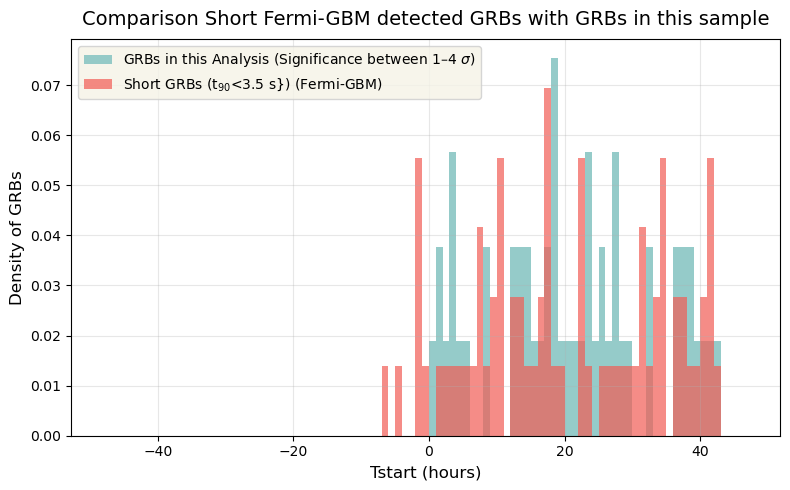

In [ ]:
# Limpieza de datos

GRBs_sample1_4=DF_1_4sig['GRB'].to_list()
GRBs_sample1_2=DF_1_2sig['GRB'].to_list()

Fermi_wo_GRBs=FERMI[~FERMI['GRB'].isin(GRBs_sample1_4)]


GRBs_sample1_4=DF_1_4sig['GRB'].to_list()
Fermi_w_1_4GRBs=FERMI[FERMI['GRB'].isin(GRBs_sample1_4)]
Fermi_w_1_2GRBs=FERMI[FERMI['GRB'].isin(GRBs_sample1_2)]

Fermi_w_1_4GRBs_start=Fermi_w_1_4GRBs['Tent-T0_y'].to_list() + Fermi_w_1_4GRBs['Tent-T0_x'].to_list()
Fermi_w_1_2GRBs_start=Fermi_w_1_2GRBs['Tent-T0_y'].to_list() + Fermi_w_1_2GRBs['Tent-T0_x'].to_list()
GRBList_df=DF

# # Cálculo de la segunda órbita y combinación de tiempos
Tstart_FERMI_no = Fermi_wo_GRBs['Tent-T0_y'].to_list() + Fermi_wo_GRBs['Tent-T0_x'].to_list()
Fermi_wo_GRBs.columns
# Figura y ejes
plt.figure(figsize=(8, 5))

# Histograma de GRBs cortos observados por Fermi
plt.hist(Fermi_w_1_4GRBs_start,
    bins=np.arange(0,48,1), 
    density=True, 
    alpha=0.9, 
    label=r'GRBs in this Analysis (Significance between 1–4 $\sigma$)', 
    color='#8ac6c3'
)
plt.hist(Fermi_w_1_2GRBs_start, 
    bins=np.arange(-48,48,1), 
    density=True, 
    label=r'Short GRBs (t$_{90}$<3.5 s}) (Fermi-GBM)', 
    color='#f25c54', 
    alpha=0.7
)
# plt.hist(
#     Tstart_FERMI_no, 
#     bins=np.arange(-48,48,1), 
#     density=True, 
#     label=r'Short GRBs (t$_{90}$<3.5 s}) (Fermi-GBM) excluding current analysis bursts in the 1-4 $\sigma$ range', 
#     color='#14213d', 
#     alpha=0.7
# )

# Histograma de los GRBs analizados en tu estudio


# Personalización del gráfico
plt.xlabel('Tstart (hours)', fontsize=12)
plt.ylabel('Density of GRBs', fontsize=12)
plt.title('Comparison Short Fermi-GBM detected GRBs with GRBs in this sample', fontsize=14, pad=10)
plt.legend(facecolor='#f5f3e7')
plt.grid(alpha=0.3)
plt.tight_layout()
print('Estos GRBs tienen o no redshift')
# Mostrar figura
plt.show()


Si quitamos nuestra muestra de Fermi:
Fermi['GRBs']

In [ ]:

grb='GRB170803729'
grb='GRB170816599'
# grb='GRB170826369'
GRBList_df[GRBList_df['GRB']==grb]
GRBList_df
FERMI.columns

Index(['Unnamed: 0.1_x', 'Unnamed: 0_x', 'GRB', 'Ra_x', 'Dec_x',
       'Trigger_MJD_x', 't_entry_MJD_x', 't_max_MJD_x', 't_exit_MJD_x',
       'delta_t_entry_hr_x', 'Transit_time_x', 'Tent-T0_x', 'Texit-Tmax_x',
       'transit_x', 'Unnamed: 0.1_y', 'Unnamed: 0_y', 'Ra_y', 'Dec_y',
       'Trigger_MJD_y', 't_entry_MJD_y', 't_max_MJD_y', 't_exit_MJD_y',
       'delta_t_entry_hr_y', 'Transit_time_y', 'Tent-T0_y', 'Texit-Tmax_y',
       'transit_y'],
      dtype='object')

/tmp/ipykernel_2946342/1596202981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fermi_wo_GRBs.dropna(inplace=True)
/tmp/ipykernel_2946342/1596202981.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fermi_wo_GRBs['second_transit'] = Fermi_wo_GRBs['Tent-T0'] + 24


Estos GRBs tienen o no redshift


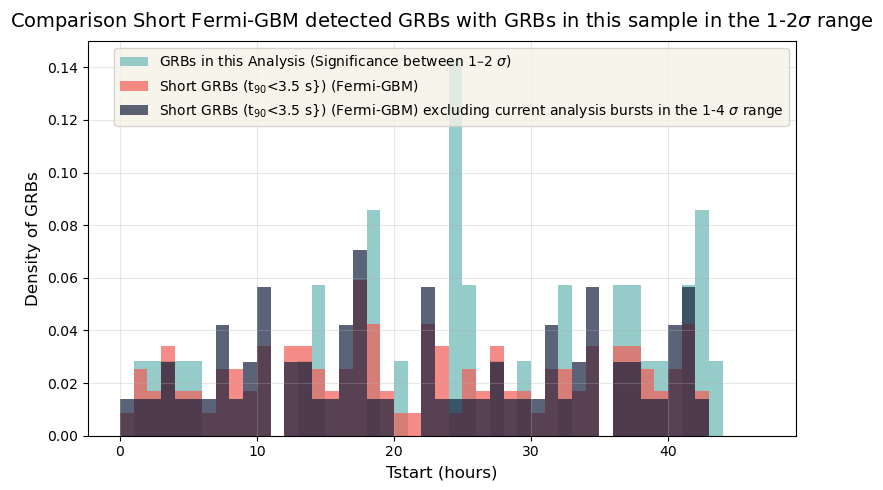

In [ ]:
# Limpieza de datos

GRBs_sample=DF_1_2sig['GRB'].to_list()
Fermi_wo_GRBs=FERMI[~FERMI['GRB'].isin(GRBs_sample)]
GRBList_df=DF
Fermi_wo_GRBs.dropna(inplace=True)

# Cálculo de la segunda órbita y combinación de tiempos
Fermi_wo_GRBs['second_transit'] = Fermi_wo_GRBs['Tent-T0'] + 24
Tstart_FERMI_no = Fermi_wo_GRBs['second_transit'].to_list() + Fermi_wo_GRBs['Tent-T0'].to_list()

# Figura y ejes
plt.figure(figsize=(8, 5))

# Histograma de GRBs cortos observados por Fermi
DF_1_2sig['Tstart (h)'].hist(
    bins=np.arange(0,48,1), 
    density=True, 
    alpha=0.9, 
    label=r'GRBs in this Analysis (Significance between 1–2 $\sigma$)', 
    color='#8ac6c3'
)
plt.hist(
    Tstart_FERMI, 
    bins=np.arange(0,48,1), 
    density=True, 
    label=r'Short GRBs (t$_{90}$<3.5 s}) (Fermi-GBM)', 
    color='#f25c54', 
    alpha=0.7
)
plt.hist(
    Tstart_FERMI_no, 
    bins=np.arange(0,48,1), 
    density=True, 
    label=r'Short GRBs (t$_{90}$<3.5 s}) (Fermi-GBM) excluding current analysis bursts in the 1-4 $\sigma$ range', 
    color='#14213d', 
    alpha=0.7
)

# Histograma de los GRBs analizados en tu estudio


# Personalización del gráfico
plt.xlabel('Tstart (hours)', fontsize=12)
plt.ylabel('Density of GRBs', fontsize=12)
plt.title(r'Comparison Short Fermi-GBM detected GRBs with GRBs in this sample in the 1-2$\sigma$ range', fontsize=14, pad=10)
plt.legend(facecolor='#f5f3e7')
plt.grid(alpha=0.3)
plt.tight_layout()
print('Estos GRBs tienen o no redshift')
# Mostrar figura
plt.show()


# Limpieza de datos
Fermi_wo_GRBs.dropna(inplace=True)

# Cálculo de la segunda órbita y combinación de tiempos
Fermi_wo_GRBs['second_transit'] = Fermi_wo_GRBs['Tent-T0'] + 24
Tstart_FERMI_no = Fermi_wo_GRBs['second_transit'].to_list() + Fermi_wo_GRBs['Tent-T0'].to_list()

# Figura y ejes
plt.figure(figsize=(8, 5))

# Histograma de GRBs cortos observados por Fermi
DF_1_2sig['Tstart (h)'].hist(
    bins=np.arange(0,48,1), 
    density=True, 
    alpha=0.9, 
    label=r'GRBs in this Analysis (Significance between 1–2 $\sigma$)', 
    color='#8ac6c3'
)
plt.hist(
    Tstart_FERMI, 
    bins=np.arange(0,48,1), 
    density=True, 
    label=r'Short GRBs (t$_{90}$<3.5 s}) (Fermi-GBM)', 
    color='#f25c54', 
    alpha=0.7
)
plt.hist(
    Tstart_FERMI_no, 
    bins=np.arange(0,48,1), 
    density=True, 
    label=r'Short GRBs (t$_{90}$<3.5 s}) (Fermi-GBM) excluding current analysis bursts in 1-2 ', 
    color='#14213d', 
    alpha=0.7
)

# Histograma de los GRBs analizados en tu estudio


# Personalización del gráfico
plt.xlabel('Tstart (hours)', fontsize=12)
plt.ylabel('Density of GRBs', fontsize=12)
plt.title(r'Comparison Short FErmi-GBM detected GRBs with GRBs in this analysis ranging from 1 to 2 $\sigma$ significance', fontsize=14, pad=10)
plt.legend(facecolor='#f5f3e7')
plt.grid(alpha=0.3)
plt.tight_layout()
print('Estos GRBs tienen o no redshift')
# Mostrar figura
plt.show()


In [ ]:
len(FERMI),len(Fermi_wo_GRBs),len(DF_1_2sig['GRB'].drop_duplicates()),len(DF['GRB'].drop_duplicates())


(68, 39, 29, 42)

In [ ]:
print('De aquí los que tienen kilonova son GRB 170817A, 160821B y 150101B.')
grb_w_KN=['GRB150101641','GRB160821937','GRB170817529']
for grb in grb_w_KN:
    t=DF[DF['GRB']==grb]['Tstart (h)'].values[0]
    print(f'El tiempo de entrada al FOV de HAWC del {grb} es {t}')

De aquí los que tienen kilonova son GRB 170817A, 160821B y 150101B.
El tiempo de entrada al FOV de HAWC del GRB150101641 es 18.592370000018015
El tiempo de entrada al FOV de HAWC del GRB160821937 es 3.4779630555709202
El tiempo de entrada al FOV de HAWC del GRB170817529 es 8.202368055582047


13

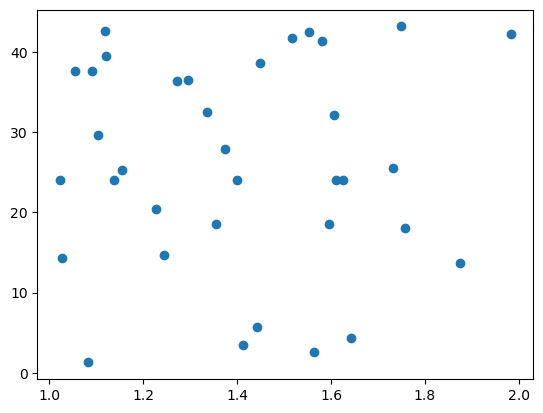

In [ ]:
plt.scatter(DF_1_2sig['sigma_post'],DF_1_2sig['Tstart (h)'])
len(DF_1_2sig[(DF_1_2sig['sigma_post']>1.4)&(DF_1_2sig['Tstart (h)']>12)])

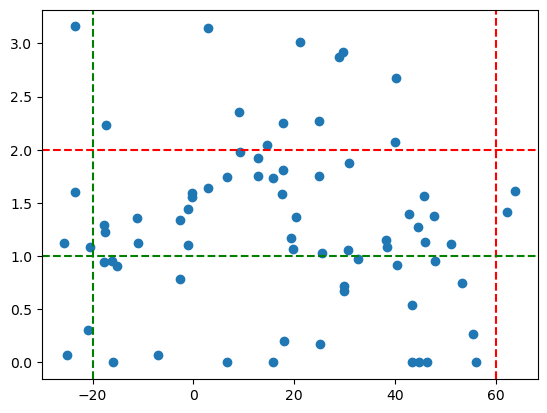

In [ ]:
Sig=DF['max_sigma']
Zenith=abs(DF['dec_max']-19)
Dec=DF['dec_max']
plt.axvline(x=60, color='r', linestyle='--', label='Umbral 0.5')
plt.axvline(x=-20, color='g', linestyle='--', label='Umbral 0.5')
plt.axhline(y=2, color='r', linestyle='--', label='Umbral 0.5')
plt.axhline(y=1, color='g', linestyle='--', label='Umbral 0.5')
plt.scatter(Dec,Sig)

<Axes: >

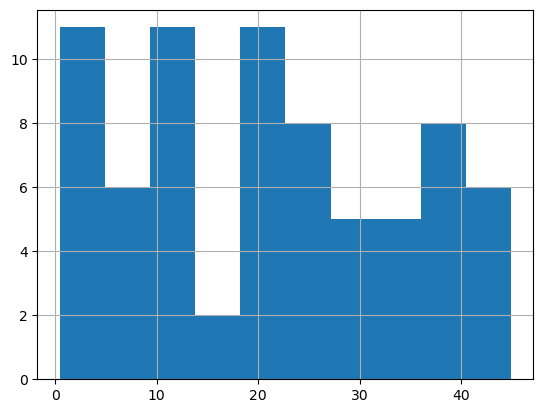

In [ ]:
Zenith.hist()

In [ ]:
DF[(DF['max_sigma']<2.5)&(DF['max_sigma']>2.0)]

,GRB,transit,seed,ra_max,dec_max,max_sigma,region_size_deg,trials_factor,p_pre,p_post,...,flnc_sbpl_statistic,bcatalog,scatalog,last_modified,Unnamed: 307,Trigger_time(mjd),Fermi_Name,z_wo_pseudo,GPS trigger,Tstart (h)
3,GRB150819440,transit_2,GRB150819440_transit_2FINAL_C0,58.930664,39.935668,2.074497,0.50,2.777778,0.019017,0.051935,...,Castor C-STAT,3,3,2018-07-06 13:48:52.00,NaN,57253.439809,GRB150819440,0.0,1.124016e+09,24.000000
12,GRB170206453,transit_2,GRB170206453_transit_2FINAL_C0,212.255859,14.670223,2.043394,0.85,8.027778,0.020507,0.153237,...,Castor C-STAT,3,3,2017-02-23 15:57:38.00,NaN,57790.452751,GRB170206453,0.0,1.170414e+09,24.000000
16,GRB170403583,transit_2,GRB170403583_transit_2FINAL_C0,259.277344,17.700204,2.250479,0.70,5.444444,0.012209,0.064694,...,Castor C-STAT,3,3,2019-03-18 21:16:23.00,NaN,57846.582845,GRB170403583,0.0,1.175263e+09,41.769501
32,GRB180418281,transit_2,GRB180418281_transit_2FINAL_C0,170.419922,24.994170,2.265931,0.30,1.000000,0.011728,0.011728,...,Castor C-STAT,3,3,2018-10-29 16:16:45.00,NaN,58226.280628,GRB180418281,0.0,1.208069e+09,42.081311
38,GRB180805543,transit_2,GRB180805543_transit_2FINAL_C0,25.532227,-17.426323,2.237625,0.30,1.000000,0.012623,0.012623,...,PSTAT,3,5,2024-12-18 14:11:01.00,NaN,58335.543478,GRB180805543,0.0,1.217509e+09,44.393468
49,GRB201214672,transit_1,GRB201214672_transit_1FINAL_C0,187.690430,9.064839,2.355880,0.30,1.000000,0.009239,0.009239,...,PSTAT,3,5,2024-12-17 16:28:41.00,NaN,59197.672067,GRB201214672,0.0,1.291997e+09,18.246773


In [ ]:
Fisher_Test['p_val (Fisher)']=Fisher_Test.apply(lambda row: chi2.sf(row['T_stat'],2*row['n_elem']),axis=1)
Fisher_Test

,PSF,T_stat,n_elem,Crit_val,p_val (Fisher)


The probability of having values greater than 3 sigma with the non-parametric distribution  is: 0.02609177192147948
and directly from data is: 0.0036383682469680267


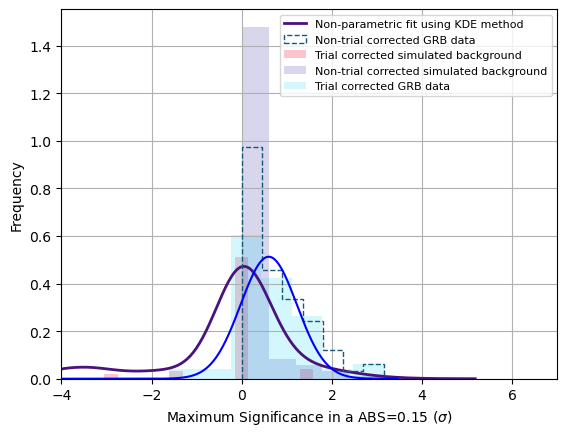

The probability of having values greater than 3 sigma with the non-parametric distribution  is: 0.04575935011545966
and directly from data is: 0.009475539885412075


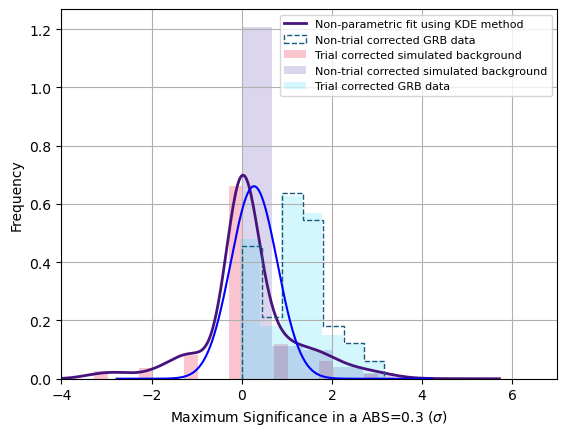

The probability of having values greater than 3 sigma with the non-parametric distribution  is: 0.09875735895766946
and directly from data is: 0.035706240144176615


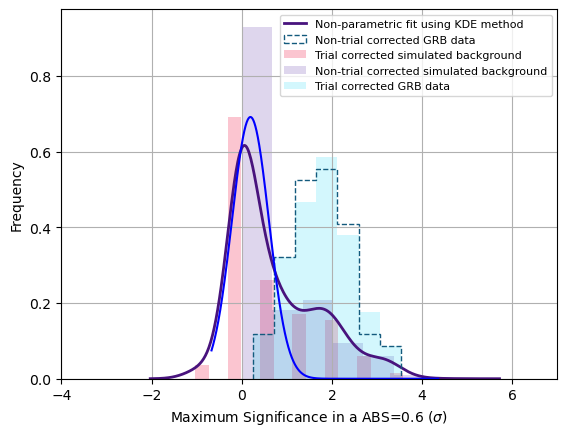

In [ ]:
#now this is my sample but how can I do this plote with no backgrounf and ith dark mode so the lines are all is white import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy.stats import kstest,gaussian_kde,chi2
PSF = [0.15,0.3,0.6]
j = 2
sig_name = 'sigma_post'
Fisher_T_statistics={'PSF':[],'T_stat':[],'n_elem':[],'Crit_val':[]}
def normal_fixedA(x, mu, sigma, A0):
    """Gaussian with amplitude A0 fixed externally."""
    return A0 * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

for i in PSF:
    name_1 = f'Files/Max/grb_all_seed_maxima_PSF{i}_free.csv'
    df_1 = pd.read_csv(name_1)

    name_2 = f'Files/Max/grb_all_seed_maxima_PSF{i}_fixed.csv'
    df_2 = pd.read_csv(name_2)

    
    name_3 = f'Files/Max/grb_all_seed_maxima_PSF{i}_free_data.csv'
    df_3 = pd.read_csv(name_3)
    
    name_4 = f'Files/Max/grb_all_seed_maxima_PSF{i}_fixed_data.csv'
    df_4 = pd.read_csv(name_4)
    
    j = j + 1
    data = df_1[sig_name]

    # Describing  the data
    mu = data.mean()
    std = data.std()
    S = data.skew()
    K = data.kurt()
    Tstat, p_value = kstest(data, 'norm', args=(mu, std))

    hist, bins = np.histogram(data,bins=8,density=True)
    A0 = hist.max()
    mu0 = data.mean()
    sigma0 = data.std()
    centers = 0.5 * (bins[:-1] + bins[1:]) 
    popt, pcov = curve_fit(
        lambda x, mu, sigma: normal_fixedA(x, mu, sigma, A0),
        centers,
        hist,
        p0=[mu0, sigma0]
    )
    mu_fit, sigma_fit = popt
    x_fit = np.linspace(centers.min(), centers.max(), 2000)

    # --- Non-parametric density estimate and visualization ---

    # Build a kernel-density estimate from the same data
    kde = gaussian_kde(data, bw_method=0.35)  # or 'silverman' / float for bandwidth
    x_kde = np.linspace(data.min() - 1, data.max() + 1, 400)
    y_kde = kde(x_kde)
    def pdf(x):
        return(float(kde([x])))
    p_val_right=scipy.integrate.quad(pdf,3,np.inf,limit=200)[0]
    p_val_right=scipy.integrate.quad(pdf,2,3,limit=200)[0]
    p_val=()
    print('The probability of having values greater than 3 sigma with the non-parametric distribution  is:',p_val_right)
    print('and directly from data is:',len(data[data>3])/len(data))
    # Overlay the KDE curve
    plt.plot(
        x_kde,
        y_kde,
        color='#48137d',
        lw=2,
        label='Non-parametric fit using KDE method'
    )
    #gaussian fit

    df_4[sig_name].hist(
        bins=7,
        histtype='step',            # <-- outline only
        linewidth=1,  
        ls='dashed',# optional: thicker lines
        color='#135a7d',
        label='Non-trial corrected GRB data',
        density=True
    )
    ########################################################################
    # Fisher Test
    ########################################################################
    sigma_lim=3
    def PVal(x_data):
        p_val=-2*np.log(scipy.integrate.quad(kde,x_data,np.inf,limit=200)[0])
        return p_val
    GRB_data=df_4[df_4[sig_name]<sigma_lim][sig_name]
    Fisher_statistic=GRB_data.apply(PVal).sum();n_elem=len(GRB_data) 
    # #Finding the critical value
    Crit_val=chi2.ppf(0.95,2*n_elem)
    Fisher_T_statistics['PSF'].append(i)
    Fisher_T_statistics['T_stat'].append(Fisher_statistic)
    Fisher_T_statistics['n_elem'].append(n_elem)
    Fisher_T_statistics['Crit_val'].append(Crit_val)
    plt.plot(x_fit,
            normal_fixedA(x_fit, mu_fit, sigma_fit, A0),
            "b-")

    # plt.hist(data,bins=bins,
    #         color=f'#f{j}4266',
    #         alpha=0.3,
    #         label=fr'max(PSF,Fermi_error),S={S:.2f},K={K:.2f},stat_KS={Tstat:.2f},p$_v$={p_value:.2f}',
    #         density=True,width=0.3)
    plt.hist(data,bins=bins,
            color=f'#f{j}4266',
            alpha=0.3,
            label=fr'Trial corrected simulated background',
            density=True,width=0.3)

    df_2[                  sig_name].hist(bins=7,
                        color=f'#{j}e32a8',  
                        alpha=0.2,
                        label='Non-trial corrected simulated background',
    density=True)
    df_3[                  sig_name].hist(bins=7,
                        color=f'#27DAF5',  
                        alpha=0.2,
                        label='Trial corrected GRB data',
    density=True)
    plt.legend(fontsize='8')
    plt.xlim([-4,7])
    plt.ylabel('Frequency')
    plt.xlabel(fr'Maximum Significance in a ABS={i} ($\sigma$) ')
    plt.savefig(f"plots/PSF{i}_wData.png", dpi=300, bbox_inches='tight')
    plt.show()
Fisher_Test=pd.DataFrame(Fisher_T_statistics)

,PSF,T_stat,n_elem,Crit_val,p_val (Fisher),sig (Fisher)
0,0.15,221.246009,71,170.809198,2.326661e-05,4.072390
1,0.30,265.756242,71,170.809198,1.488969e-09,5.932810
2,0.60,249.248941,70,168.612954,3.810856e-08,5.375862


In [ ]:
norm.sf(6.6)

2.0557889093995235e-11